# Model with pretrained embeddings
    - Glove embeddings. Vectors of 300 dim.
    - Model: Basic LSTM.


In [1]:
# Header
from __future__ import print_function

import numpy as np
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)
import time

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
#plt.rcParams['image.cmap'] = 'gray'  # use grayscale 


# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

data_path = '/home/ubuntu/data/training/text/sentiment/'

Tensorflow version:  1.2.1


## Preprocess data

In [2]:
# Import train and test data
X_train = np.load(data_path + 'aclImdb/X_train.npy')
y_train = np.load(data_path + 'aclImdb/y_train.npy')
X_test  = np.load(data_path + 'aclImdb/X_test.npy')
y_test  = np.load(data_path + 'aclImdb/y_test.npy')

print(X_train.shape, y_train.shape)
print(X_test.shape,  y_test.shape)

(25000, 200) (25000,)
(25000, 200) (25000,)


## Load embeddings and join with the current dictionary

In [3]:
#Load embeddings
import pandas as pd
import csv
import pickle

# Load worddict
with open(data_path + 'worddict.pickle', 'rb') as pfile:
    worddict = pickle.load(pfile)

embed_dim = 300
df_glove = pd.read_csv(data_path + "glove.6B."+str(embed_dim)+"d.txt", index_col=0 ,sep=' ',
                   header = None, quoting=csv.QUOTE_NONE, encoding='utf-8')

#Merge with the dictionary of the current texts: Inner join, only words in the corpus and in glove.
df_glove = df_glove.merge(pd.DataFrame.from_dict(worddict, orient='index'), left_index=True, right_index=True)
print('Merged words: ', df_glove.shape[0])

#Create dictionary: word_number_id --> [glove vector associated]
glove={}
for i,r in df_glove[:].iterrows():
    glove[int(r[0])] = [r[j] for j in range(1,embed_dim+1)]
print('Dictionary length: ', len(glove))

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/data/training/text/sentiment/worddict.pickle'

## Prepare sequences to model


In [4]:
#Create embeddings 3D tensors
max_len = 100

def embedd(x):
    r = np.zeros((max_len, embed_dim))
    pos = max_len-1
    for i in range(len(x),0,-1):
        found = True
        try:
            v = np.array([glove[x[i-1]]])
        except:
            found = False
        if found and pos>=0:
            r[pos,:] = v 
            pos += -1
    return r
        
X_train = np.array([embedd(s) for s in X_train], dtype=np.float32)
print('Train shape:', X_train.shape)

X_test = np.array([embedd(s) for s in X_test], dtype=np.float32)
print('Test shape:', X_test.shape)

Train shape: (25000, 100, 300)
Test shape: (25000, 100, 300)


In [7]:
# Save data in HDF5 to use with a batch generator
import h5py
with h5py.File(data_path + 'sentiment_glove_data.h5') as hdf5_f:
    hdf5_f.create_dataset('X_train', data=np.array(X_train))
    hdf5_f.create_dataset('y_train', data=np.array(y_train))
    hdf5_f.create_dataset('X_test' , data=np.array(X_test ))
    hdf5_f.create_dataset('y_test' , data=np.array(y_test ))


## Build model

In [5]:
# Model
num_hidden_rnn = 128 #Num of neurons in the Recurent network 

from tensorflow.contrib.keras import layers, models, optimizers

print('Build model 1 - Basic model...')

# LAYER 1: inputs
seq_prev_input = layers.Input(shape=(max_len, embed_dim), dtype='float32') 

# LAYER 2: Create embedings
#embeds = layers.Embedding(max_features, dim_embedings, input_length=max_len)(seq_prev_input)

# LAYERS 3: RNN - forwards LSTM with dropout
forward = layers.LSTM(num_hidden_rnn, return_sequences=True,
                 dropout=0.3, recurrent_dropout=0.3, name='Forward1')(seq_prev_input)
rnn_out = layers.LSTM(num_hidden_rnn, return_sequences=False,
                 dropout=0.3, recurrent_dropout=0.3, name='Forward2')(forward)


# LAYER 4: Dense layer to outputs - softmax activation
output = layers.Dense(2, activation='softmax')(rnn_out)

# Model Architecture defined
model_1 = models.Model(inputs=seq_prev_input, outputs=output)
model_1.summary()

# Compile model and select optimizer
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


Build model 1 - Basic model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 300)          0         
_________________________________________________________________
Forward1 (LSTM)              (None, None, 128)         219648    
_________________________________________________________________
Forward2 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 351,490
Trainable params: 351,490
Non-trainable params: 0
_________________________________________________________________


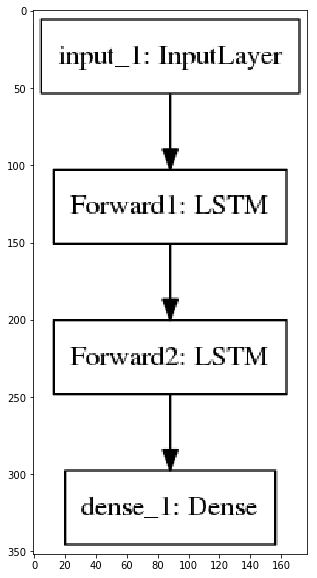

In [6]:
#Plot the model graph
from tensorflow.contrib.keras import utils

# Create model image
utils.plot_model(model_1, '/tmp/model1.png')

# Show image
plt.imshow(plt.imread('/tmp/model1.png'))


In [7]:
# Train
batch_size = 128

print("Train...")
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=20,
                      validation_data=(X_test, y_test))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 81s - loss: 0.5931 - acc: 0.6776 - val_loss: 0.4619 - val_acc: 0.7869
Epoch 2/20
25000/25000 [==============================] - 82s - loss: 0.4724 - acc: 0.7800 - val_loss: 0.3950 - val_acc: 0.8239
Epoch 3/20
25000/25000 [==============================] - 81s - loss: 0.4128 - acc: 0.8112 - val_loss: 0.3706 - val_acc: 0.8309
Epoch 4/20
25000/25000 [==============================] - 81s - loss: 0.3875 - acc: 0.8246 - val_loss: 0.3644 - val_acc: 0.8401
Epoch 5/20
25000/25000 [==============================] - 81s - loss: 0.3725 - acc: 0.8332 - val_loss: 0.3428 - val_acc: 0.8468
Epoch 6/20
25000/25000 [==============================] - 81s - loss: 0.3508 - acc: 0.8452 - val_loss: 0.3370 - val_acc: 0.8488
Epoch 7/20
25000/25000 [==============================] - 82s - loss: 0.3375 - acc: 0.8498 - val_loss: 0.3324 - val_acc: 0.8533
Epoch 8/20
25000/25000 [=====================

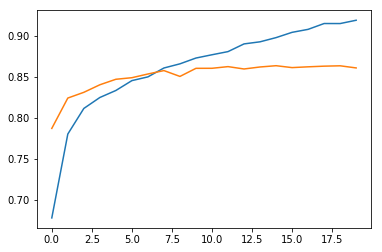

In [8]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

## Validate it

In [9]:
# Score and obtain probabilities
pred_test = model_1.predict(X_test)
print(pred_test.shape)

(25000, 2)


Accuracy:  0.86068
AUC:  0.9397282624


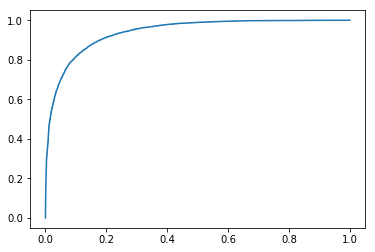

In [10]:
#Import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score

#Calculate accuracy with sklearn
print('Accuracy: ',accuracy_score(y_test, [1 if p>0.5 else 0 for p in pred_test[:,1]]))

#Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test[:,1])
print('AUC: ', auc(fpr, tpr) ) 

#Plot ROC curve
plt.plot(fpr, tpr)